In [110]:
import pandas as pd
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from nltk.sentiment import SentimentIntensityAnalyzer
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
from nltk import download

# Download required NLTK resources
download('stopwords')
download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/arushimunjal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/arushimunjal/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [116]:
spotify_songs = pd.read_csv('/Users/arushimunjal/Desktop/Group145-FA24/spotify_songs.csv')
songs_popularity_genres = pd.read_csv('/Users/arushimunjal/Desktop/Group145-FA24/songs_normalize.csv')
songs_lyrics = pd.read_csv('/Users/arushimunjal/Desktop/Group145-FA24/labeled_Lyrics_Cleaned.csv')

# Clean Spotify Songs dataset
spotify_songs['track_album_release_date'] = pd.to_datetime(
    spotify_songs['track_album_release_date'], errors="coerce"
)

# Extract year from date
spotify_songs['year_released'] = spotify_songs['track_album_release_date'].dt.year
spotify_songs = spotify_songs.dropna(subset=['year_released'])
spotify_songs['year_released'] = spotify_songs['year_released'].astype(int)
spotify_songs = spotify_songs[
    (spotify_songs['year_released'] >= 2000) & (spotify_songs['year_released'] <= 2023)
]
spotify_songs = spotify_songs[spotify_songs['language'] == 'en']

# Drop unnecessary columns
spotify_songs = spotify_songs.drop(
    columns=[
        'track_album_release_date',
        'track_artist',
        'track_album_id',
        'track_album_name',
        'playlist_name',
        'playlist_id',
        'playlist_subgenre',
        'duration_ms',
        'language'
    ]
)

spotify_songs = spotify_songs.rename(columns={'track_name': 'song'})

# Merge songs_popularity_genres and songs_lyrics on 'song'
merged_df = pd.merge(songs_popularity_genres, songs_lyrics, on='song', how='inner')

# Select and rename relevant columns
cleaned_df = merged_df[['song', 'popularity', 'year', 'genre', 'seq']].rename(
    columns={
        'seq': 'lyrics',
        'popularity': 'track_popularity',
        'year': 'year_released',
        'genre': 'playlist_genre'
    }
)

# Filter by year of release
filtered_df = cleaned_df[
    (cleaned_df['year_released'] >= 2000) & (cleaned_df['year_released'] <= 2023)
]

# Remove duplicate songs
unique_songs_df = filtered_df.drop_duplicates(subset='song', keep='first')

# Define target genres
unique_genres = ['pop', 'rap', 'rock', 'r&b']

# Function to clean and simplify genres
def clean_genre(genre):
    first_genre = genre.split(',')[0].strip().lower()
    return first_genre if first_genre in unique_genres else 'other'

# Apply the cleaning function to the 'playlist_genre' column
unique_songs_df['playlist_genre'] = unique_songs_df['playlist_genre'].apply(clean_genre)

# Filter for only target genres
unique_songs_df = unique_songs_df[unique_songs_df['playlist_genre'].isin(unique_genres)]

# Combine with Spotify Songs dataset
final_df = pd.concat([spotify_songs, unique_songs_df], ignore_index=True)

# Filter for only target genres
final_df = final_df[final_df['playlist_genre'].isin(unique_genres)]

# Display the cleaned dataset
final_df.head()

/var/folders/mk/l_2r3ynj1014_n9tnz_kk76w0000gn/T/ipykernel_26498/4017537064.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_songs_df['playlist_genre'] = unique_songs_df['playlist_genre'].apply(clean_genre)


,track_id,song,lyrics,track_popularity,playlist_genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,year_released
0,004s3t0ONYlzxII9PLgU6z,I Feel Alive,"The trees, are singing in the wind The sky blu...",28,rock,0.303,0.880,9.0,-4.739,1.0,0.0442,0.01170,0.00994,0.3470,0.404,135.225,2017
1,00chLpzhgVjxs1zKC9UScL,Poison,"NA Yeah, Spyderman and Freeze in full effect U...",0,r&b,0.845,0.652,6.0,-7.504,0.0,0.2160,0.00432,0.00723,0.4890,0.650,111.904,2005
2,00cqd6ZsSkLZqGMlQCR0Zo,Baby It's Cold Outside (feat. Christina Aguilera),I really can't stay Baby it's cold outside I'v...,41,r&b,0.425,0.378,5.0,-5.819,0.0,0.0341,0.68900,0.00000,0.0664,0.405,118.593,2012
3,00emjlCv9azBN0fzuuyLqy,Dumb Litty,Get up out of my business You don't keep me fr...,65,pop,0.760,0.887,9.0,-1.993,1.0,0.0409,0.03700,0.00000,0.1380,0.240,130.018,2019
4,00f9VGHfQhAHMCQ2bSjg3D,Soldier,"Hold your breath, don't look down, keep trying...",70,r&b,0.496,0.639,6.0,-6.157,1.0,0.0550,0.28000,0.00000,0.0975,0.305,147.764,2019


In [115]:
# Find the minimum number of songs across genres
min_songs_per_genre = final_df.groupby('playlist_genre').size().min()

# Select top songs for each genre
top_songs = final_df.groupby('playlist_genre').apply(
    lambda x: x.nlargest(min_songs_per_genre, 'track_popularity')
).reset_index(drop=True)

# Check the balance
top_songs['playlist_genre'].value_counts()

/var/folders/mk/l_2r3ynj1014_n9tnz_kk76w0000gn/T/ipykernel_26498/3522954023.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_songs = final_df.groupby('playlist_genre').apply(


playlist_genre
pop     1605
r&b     1605
rap     1605
rock    1605
Name: count, dtype: int64

In [104]:
# Preprocessing function
def preprocess_lyrics_simple(lyrics):
    custom_stopwords = set(stopwords.words('english')).union({
        'oh', 'yeah', 'na', 'll', 'baby', 'let', 'ca', 'wan', 've', 'ai', 'way',
        'come', 'ooh', 'gon', 'say', 'like', 'know', 'got', 'cause', 'im'
    })
    lyrics = lyrics.lower()
    lyrics = re.sub(r"'ll|n't|'ve|'re|'m|'d|'s", '', lyrics)
    lyrics = re.sub(r"'", '', lyrics)
    lyrics = lyrics.translate(str.maketrans('', '', string.punctuation))
    words = lyrics.split()
    words = [word for word in words if word not in custom_stopwords]
    return ' '.join(words)

# Apply preprocessing to the lyrics
top_songs['lyrics_cleaned'] = top_songs['lyrics'].fillna('').apply(preprocess_lyrics_simple)

# Display cleaned lyrics
top_songs[['song', 'lyrics_cleaned']].head()

,song,lyrics_cleaned
0,Dance Monkey,god see shine take hands dear place mine stopp...
1,Blinding Lights,tryna call long enough maybe show love maybe g...
2,Circles,could turn around til upside bad guy proud cou...
3,Memories,ones cheers wish drinks bring back memories ev...
4,everything i wanted,dream everything wanted think bein honest migh...


In [105]:
# Define thematic dictionaries
themes_dict = {
    'love': ['love', 'heart', 'girl', 'romance', 'passion', 'relationship', 'feel', 'want', 'need'],
    'empowerment': ['strong', 'fight', 'life', 'power', 'courage', 'resilience'],
    'struggle': ['away', 'hold', 'leave', 'pain', 'hardship', 'battle'],
    'celebration': ['night', 'tonight', 'good', 'party', 'fun', 'happy'],
    'nostalgia': ['time', 'home', 'world', 'memory', 'past', 'remember']
}

# Function to assign primary theme
def assign_theme(lyrics, theme_dict):
    word_counts = {theme: sum(lyrics.count(word) for word in words) for theme, words in theme_dict.items()}
    return max(word_counts, key=word_counts.get) if max(word_counts.values()) > 0 else 'None'

# Apply the function to assign themes
top_songs['primary_theme'] = top_songs['lyrics_cleaned'].apply(lambda x: assign_theme(x, themes_dict))


In [106]:
theme_lyrics = top_songs.groupby('primary_theme')['lyrics_cleaned'].apply(lambda x: ' '.join(x)).reset_index()

corpus = theme_lyrics['lyrics_cleaned']
themes = theme_lyrics['primary_theme']

vectorizer = TfidfVectorizer(
    max_features=100,  # Number of top words to extract per theme
    stop_words='english',
    ngram_range=(1, 1)  # Use unigrams (single words)
)

# Fit the TF-IDF model on the corpus
tfidf_matrix = vectorizer.fit_transform(corpus)

# Get the feature names (words)
tfidf_words = vectorizer.get_feature_names_out()

# Convert the matrix to a DataFrame for better readability
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=themes, columns=tfidf_words)

# Display the top TF-IDF scores per theme
tfidf_df.head()

,ah,ass,away,ayy,bad,best,better,big,bitch,body,...,walk,wanna,want,watch,wo,woo,work,world,ya,yo
primary_theme,,,,,,,,,,,,,,,,,,,,,
None,0.053557,0.028354,0.000000,0.192174,0.025203,0.034654,0.044105,0.025203,0.242580,0.018902,...,0.031504,0.116564,0.000000,0.063008,0.166971,0.018902,0.028354,0.000000,0.066158,0.009451
celebration,0.031641,0.020742,0.052749,0.063985,0.071719,0.019688,0.053262,0.050450,0.108458,0.026016,...,0.022324,0.174904,0.094339,0.034981,0.085079,0.021973,0.041660,0.049300,0.054141,0.034278
empowerment,0.039468,0.016182,0.040086,0.076962,0.031180,0.052097,0.078936,0.028022,0.120377,0.014208,...,0.036705,0.100643,0.076982,0.088013,0.063543,0.035126,0.023681,0.053751,0.089987,0.029996
love,0.037331,0.044277,0.059913,0.075082,0.069992,0.031943,0.070741,0.036254,0.122681,0.039607,...,0.032931,0.193093,0.293447,0.028350,0.078285,0.033919,0.042780,0.045297,0.078375,0.035056
nostalgia,0.024251,0.045704,0.053108,0.077727,0.050523,0.039641,0.109751,0.060627,0.107885,0.032801,...,0.030003,0.157631,0.065308,0.032490,0.072597,0.023785,0.076639,0.168294,0.071665,0.030469


In [107]:
def extract_top_words_for_theme(tfidf_row, feature_names, top_n=10):
    sorted_indices = tfidf_row.argsort()[::-1][:top_n]
    return [feature_names[i] for i in sorted_indices]

# Create the expanded dictionary
expanded_themes = {}
for theme, row in tfidf_df.iterrows():
    expanded_themes[theme] = extract_top_words_for_theme(row.values, tfidf_words, top_n=10)

# Display the expanded themes dictionary
expanded_themes

{'None': ['nigga',
  'em',
  'fuck',
  'bitch',
  'turn',
  'ayy',
  'told',
  'shit',
  'wo',
  'gotta'],
 'celebration': ['night',
  'tonight',
  'good',
  'wanna',
  'make',
  'love',
  'time',
  'right',
  'day',
  'hey'],
 'empowerment': ['life',
  'gonna',
  'nigga',
  'day',
  'time',
  'make',
  'fuck',
  'shit',
  'right',
  'bitch'],
 'love': ['love',
  'want',
  'need',
  'feel',
  'wanna',
  'girl',
  'make',
  'time',
  'right',
  'nigga'],
 'nostalgia': ['time',
  'home',
  'world',
  'wanna',
  'make',
  'think',
  'nigga',
  'mind',
  'tell',
  'fuck'],
 'struggle': ['away',
  'hold',
  'wanna',
  'leave',
  'make',
  'bitch',
  'run',
  'time',
  'wo',
  'right']}

In [108]:
manual_themes = {
    'love': ['love', 'heart', 'romance', 'passion', 'relationship'],
    'empowerment': ['strong', 'fight', 'power', 'courage'],
    'struggle': ['pain', 'hardship', 'battle', 'tears'],
    'celebration': ['party', 'fun', 'happy', 'cheer'],
    'nostalgia': ['memory', 'past', 'yesterday', 'dream']
}

# Combine manually curated and TF-IDF extracted words
for theme in expanded_themes:
    expanded_themes[theme] = list(set(manual_themes.get(theme, []) + expanded_themes[theme]))

# Display the final expanded dictionary
expanded_themes

{'None': ['bitch',
  'told',
  'nigga',
  'gotta',
  'fuck',
  'ayy',
  'shit',
  'turn',
  'em',
  'wo'],
 'celebration': ['right',
  'tonight',
  'day',
  'night',
  'wanna',
  'make',
  'fun',
  'good',
  'time',
  'hey',
  'happy',
  'love',
  'party',
  'cheer'],
 'empowerment': ['power',
  'right',
  'bitch',
  'day',
  'nigga',
  'life',
  'courage',
  'make',
  'fuck',
  'fight',
  'time',
  'gonna',
  'shit',
  'strong'],
 'love': ['girl',
  'right',
  'nigga',
  'relationship',
  'passion',
  'wanna',
  'make',
  'time',
  'need',
  'feel',
  'heart',
  'love',
  'want',
  'romance'],
 'nostalgia': ['world',
  'home',
  'think',
  'nigga',
  'wanna',
  'make',
  'mind',
  'tell',
  'time',
  'fuck',
  'memory',
  'dream',
  'past',
  'yesterday'],
 'struggle': ['bitch',
  'right',
  'leave',
  'hold',
  'wanna',
  'make',
  'tears',
  'away',
  'battle',
  'time',
  'run',
  'wo',
  'pain',
  'hardship']}

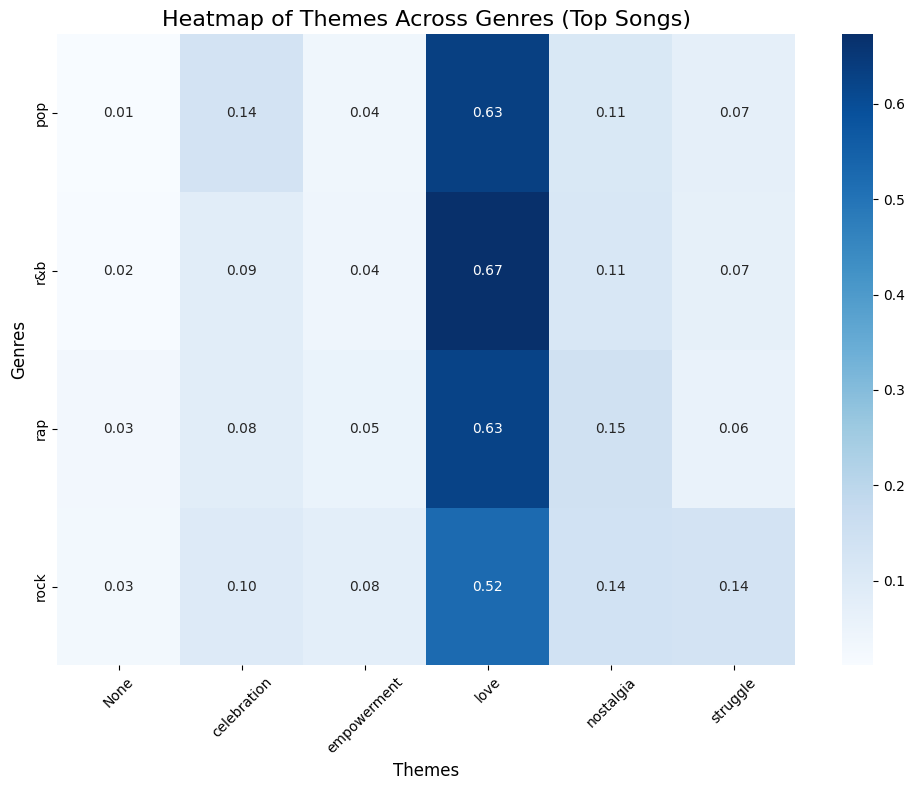

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group songs by genre and theme
theme_counts = top_songs.groupby(['playlist_genre', 'primary_theme']).size().unstack(fill_value=0)

# Normalize counts by genre to make them relative
theme_counts_normalized = theme_counts.div(theme_counts.sum(axis=1), axis=0)

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(theme_counts_normalized, annot=True, cmap='Blues', fmt=".2f", cbar=True)

# Add titles and labels
plt.title('Heatmap of Themes Across Genres (Top Songs)', fontsize=16)
plt.xlabel('Themes', fontsize=12)
plt.ylabel('Genres', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
